In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from builtins import range
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import mir_eval
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram
from global_config import *


Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [2]:
def model_multi_kernel_shape(n_out, input_shape, out_activation='softmax'):
    """

    Symbolic summary:
    > c2' - p2 - c2 - p2 - c2 - p2 - c2 - p3 - d1
    where c2' -> multiple kernel shapes

    Parameters
    ----------
        n_out: integer, number of output nodes
        input_shape: tuple, an input shape, which doesn't include batch-axis.
        out_activation: activation function on the output
    """
    audio_input = Input(shape=input_shape)

    x = Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, return_decibel_melgram=True)(audio_input)
    x = BatchNormalization(axis=channel_axis)(x)

    x1 = Conv2D(7, (20, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x2 = Conv2D(7, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x3 = Conv2D(7, (3, 20), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    x = Concatenate(axis=channel_axis)([x1, x2, x3])

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    x = Dropout(0.25)(x)

    x = GlobalAveragePooling2D()(x)

    out = Dense(n_out, activation=out_activation, kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    model = Model(audio_input, out)

    return model

def data_gen(audio_data, n_detect, nsp_excerpt, type_excerpt, hop_length=HOP_LENGTH):
    """Data generator.
    excerpt: data of one audio file.
    n_detect: number of excerpts to be detected.
    nsp_detect: number of samples in one excerpt.
    """
    
    tile_times = int(np.ceil(NSP_SRC/nsp_excerpt))

    while True:
        for i in range(n_detect):
            
            if type_excerpt == 'onset':
                src_batch = np.array([audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)]], dtype=K.floatx())
            elif type_excerpt == 'segment':
                src_batch = np.array([np.tile(audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)],tile_times)[:NSP_SRC]],
                                     dtype=K.floatx())
                
            src_batch = src_batch[:, np.newaxis, :]  # make (batch, N) to (batch, 1, N) for kapre compatible
            
            yield src_batch
            

def intervals1tointervals01(segintervals1, paudio_duration):
    idx2del = []
    for idx in np.arange(1,len(segintervals1)):
        if segintervals1[idx-1][1] >= segintervals1[idx][0]:
            segintervals1[idx] = [segintervals1[idx-1][0],segintervals1[idx][1]]
            idx2del.append(idx-1)           
    segintervals1 = np.delete(segintervals1, idx2del, axis=0)  
    
    labels = []
    segintervals01 = np.zeros((len(segintervals1)*2+1,2))
    
    for idx in range(len(segintervals01)):
        if idx==0:
            segintervals01[idx] = [0, segintervals1[0][0]]
            labels.append('np')
        elif idx==len(segintervals01)-1:
            segintervals01[idx] = [segintervals1[-1][-1],paudio_duration]
            labels.append('np')
        elif idx%2:
            segintervals01[idx] = segintervals1[int(np.floor(idx/2))]
            labels.append('p')
        else:
            segintervals01[idx] = [segintervals1[int(np.floor(idx/2)-1)][-1],segintervals1[int(np.floor(idx/2))][0]]
            labels.append('np')
            
    idx2del = []
    for idx, seginterval in enumerate(segintervals01):
        if seginterval[0]==seginterval[1]:
            idx2del.append(idx)
    segintervals01 = np.delete(segintervals01, idx2del, axis=0)
    labels = np.delete(labels, idx2del)
    
    return segintervals1, segintervals01, labels

In [4]:
dataset_name = 'pedal-times_test.npz'
model_name = 'multi_kernel'

segment_exp_name = 'segment_{}'.format(model_name)
onset_exp_name = 'onset_{}'.format(model_name)
reg_w = 1e-4
batch_size = 1

onset_threshold = 0.98
segment_threshold = 0.98

print("-" * 60)
print("Beici: Welcome! Lets do pedal segment detection on a music piece.")
print("       We're gonna use {} model.".format(model_name))
npz_path = os.path.join(DIR_PEDAL_METADATA, dataset_name)
tracks = np.load(npz_path)
filenames = tracks['filename']
pedal_offset_gt_tracks = tracks['pedal_offset']
pedal_onset_gt_tracks = tracks['pedal_onset']

print("Beici: Getting model...")
onset_model = model_multi_kernel_shape(n_out=2,input_shape=ONSET_INPUT_SHAPE)
onset_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
segment_model = model_multi_kernel_shape(n_out=2,input_shape=SEGMENT_INPUT_SHAPE)
segment_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print("       Loading the best weights...")
onset_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(onset_exp_name)))
segment_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(segment_exp_name)))

------------------------------------------------------------
Beici: Welcome! Lets do pedal segment detection on a music piece.
       We're gonna use multi_kernel model.
Beici: Getting model...
       Loading the best weights...


In [5]:
# for idx, filename in enumerate(filenames):
filename_idx = 0
filename = filenames[filename_idx]    
print("Example piece in this notebook: {}".format(filename))
paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(filename))
paudio, sr = librosa.load(paudio_path, sr=SR) 
pedal_offset_gt = np.array(pedal_offset_gt_tracks[filename_idx])
pedal_onset_gt = np.array(pedal_onset_gt_tracks[filename_idx])

Example piece in this notebook: 2011/Ahfat01


In [6]:
print("Beici: Predicting...")
len_onset_shape = int(SR * (TRIM_SECOND_BEFORE + TRIM_SECOND_AFTER))
onsethop_length = HOP_LENGTH
onsethop_duration = onsethop_length/SR
n_ponset = int(np.ceil((len(paudio)-len_onset_shape)/onsethop_length))
gen_ponset = data_gen(paudio, n_ponset, len_onset_shape, 'onset', hop_length=onsethop_length)
pred_ponset = onset_model.predict_generator(gen_ponset, n_ponset // batch_size)
pred_ponset_filter = medfilt(pred_ponset[:,1],15)
frmtime_ponset = np.arange(n_ponset)*onsethop_duration+TRIM_SECOND_BEFORE

len_segment_shape = int(SR * MIN_SRC)
seghop_length = HOP_LENGTH*10
seghop_duration = seghop_length/SR
n_psegment = int(np.ceil((len(paudio)-len_segment_shape)/seghop_length))
gen_psegment = data_gen(paudio, n_psegment, len_segment_shape, 'segment', hop_length=seghop_length)
pred_psegment = segment_model.predict_generator(gen_psegment, n_psegment // batch_size)
pred_psegment_filter = medfilt(pred_psegment[:,1],3)
frmtime_psegment = np.arange(n_psegment)*seghop_duration+MIN_SRC/2
paudio_firstonsettime = librosa.frames_to_time(librosa.onset.onset_detect(y=paudio, sr=SR), sr=SR)[0]
n_segment_tozero=0
for t in frmtime_psegment:
    if t < paudio_firstonsettime:
        n_segment_tozero+=1
    else:
        break        
pred_psegment_filter[:n_segment_tozero] = 0

pred_ponset_todetect = np.copy(pred_ponset_filter)
pred_ponset_todetect[pred_ponset_todetect<onset_threshold]=0
pred_ponset_todetect[pred_ponset_todetect>=onset_threshold]=1

pred_psegment_todetect = np.copy(pred_psegment_filter)
pred_psegment_todetect[pred_psegment_todetect<segment_threshold]=0
pred_psegment_todetect[pred_psegment_todetect>=segment_threshold]=1

Beici: Predicting...


In [26]:
# decide the initial indexes of pedal segment boundary
onseg_initidxs = []
offseg_initidxs = []
for idx, v in enumerate(pred_psegment_todetect):
    if idx>0 and idx<len(pred_psegment_todetect)-1:
        if pred_psegment_todetect[idx-1]==0 and v==1 and pred_psegment_todetect[idx+1]==1:
            onseg_initidxs.append(idx-1)
        elif pred_psegment_todetect[idx-1]==1 and v==1 and pred_psegment_todetect[idx+1]==0:
            offseg_initidxs.append(idx+1)

if offseg_initidxs[0] <= onseg_initidxs[0]:
    del offseg_initidxs[0]
if onseg_initidxs[-1] >= offseg_initidxs[-1]:
    del onseg_initidxs[-1]

if (len(onseg_initidxs) != len(offseg_initidxs)) or not len(pedal_offset_gt) or not len(pedal_onset_gt):
    print(" skip!")
else:
    onseg_idxs = []
    offseg_idxs = []
    for idx in range(len(onseg_initidxs)):
        if onseg_initidxs[idx] < offseg_initidxs[idx]:
            onseg_idxs.append(onseg_initidxs[idx])
            offseg_idxs.append(offseg_initidxs[idx])
    
    if not len(onseg_idxs) or not len(offseg_idxs):
        print("  no detection!")
        
    else:
        # decide the boundary times in seconds, combining the effect of pedal onset
        onseg_times = []
        offseg_times = []
        for idx, onseg_idx in enumerate(onseg_idxs):
            onponset_idx = onseg_idx*10-5
            if any(pred_ponset_todetect[onponset_idx-5:onponset_idx+5]):
                offseg_idx = offseg_idxs[idx]
                offseg_times.append(frmtime_psegment[offseg_idx])
                onseg_times.append(frmtime_psegment[onseg_idx])
        segintervals_est = np.stack((np.asarray(onseg_times),np.asarray(offseg_times)), axis=-1)

        # set the ground truth and estimation results frame by frame
        paudio_duration = librosa.get_duration(y=paudio, sr=SR)
        n_frames = int(np.ceil(paudio_duration/seghop_duration))
        segframes_gt = np.zeros(n_frames)
        segframes_est = np.zeros(n_frames)

        longpseg_idx = np.where((pedal_offset_gt-pedal_onset_gt)>seghop_duration)[0]
        longseg_onset_gt = pedal_onset_gt[longpseg_idx]
        longseg_offset_gt = pedal_offset_gt[longpseg_idx]
        segintervals_gt = np.stack((longseg_onset_gt,longseg_offset_gt), axis=-1)

        for idx, onset_t in enumerate(longseg_onset_gt):
            offset_t = longseg_offset_gt[idx]
            onset_frm = int(onset_t//seghop_duration)
            offset_frm = int(offset_t//seghop_duration)
            segframes_gt[onset_frm:offset_frm] = 1

        for idx, onset_t in enumerate(onseg_times):
            offset_t = offseg_times[idx]
            onset_frm = int(onset_t//seghop_duration)
            offset_frm = int(offset_t//seghop_duration)
            segframes_est[onset_frm:offset_frm] = 1   

        # set the ground truth and estimation results as interval format
        segintervals1_gt, segintervals01_gt, labels_gt = intervals1tointervals01(segintervals_gt, paudio_duration)
        segintervals1_est, segintervals01_est, labels_est = intervals1tointervals01(segintervals_est, paudio_duration)

        # Metrics for frame-wise label 'p'
        acc01_frm = accuracy_score(segframes_gt,segframes_est)
        p1_frm, r1_frm, f1_frm, support = precision_recall_fscore_support(segframes_gt,segframes_est)
        tn, fp, fn, tp = confusion_matrix(segframes_gt,segframes_est).ravel()
        fp_rate = fp/(fp+tn)
        fn_rate = fn/(fn+tp)

        # performance matrix based on boundary annotation of 'p'
        # window depends on duration of a beat
        onset_env = librosa.onset.onset_strength(paudio, sr=SR)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=SR)[0]
        beat_insecond = 60/tempo
        p1_sbr,r1_sbr,f1_sbr = mir_eval.segment.detection(segintervals1_gt, segintervals1_est, window=beat_insecond)
        r2e_deviation1, e2r_deviation1 = mir_eval.segment.deviation(segintervals1_gt, segintervals1_est)
        p01_sbr,r01_sbr,f01_sbr = mir_eval.segment.detection(segintervals01_gt, segintervals01_est, window=beat_insecond)

        # performance matrix based on structural annotation
        scores = mir_eval.segment.evaluate(segintervals01_gt, labels_gt, segintervals01_est, labels_est)
        r2e_deviation01, e2r_deviation01 = [scores['Ref-to-est deviation'], scores['Est-to-ref deviation']]
        p_pairwise, r_pairwise, f_pairwise = [scores['Pairwise Precision'], scores['Pairwise Recall'], 
                                              scores['Pairwise F-measure']]
        rand_index, adjrand_index = [scores['Rand Index'], scores['Adjusted Rand Index']]
        mutual_info, adjmutual_info, normmutual_info = [scores['Mutual Information'], scores['Adjusted Mutual Information'], 
                                                        scores['Normalized Mutual Information']]
        nce_over, nce_under, nce_f = [scores['NCE Over'], scores['NCE Under'], scores['NCE F-measure']]

In [28]:
print("=" * 60)
print("Metrics for frame-wise label 'p' of {}".format(filename))
print("-" * 50)
print("            Accuracy: {0:.4f}".format(acc01_frm))
print("           Precision: {0:.4f}".format(p1_frm[1]))
print("              Recall: {0:.4f}".format(r1_frm[1]))
print("                  F1: {0:.4f}".format(f1_frm[1]))
print("             FP rate: {0:.4f}".format(fp_rate))
print("             FN rate: {0:.4f}".format(fn_rate))
print("=" * 60)
print("Metrics for boundary annotation of {}".format(filename))
print("-" * 50)
print("     Boundary Window: {0:.4f} seconds".format(beat_insecond))
print("           Precision 'p': {0:.4f}".format(p1_sbr))
print("              Recall 'p': {0:.4f}".format(r1_sbr))
print("           F-measure 'p': {0:.4f}".format(f1_sbr))
print("Ref-to-est deviation 'p': {0:.4f}".format(r2e_deviation1))
print("Est-to-ref deviation 'p': {0:.4f}".format(e2r_deviation1))
print("               Precision: {0:.4f}".format(p01_sbr))
print("                  Recall: {0:.4f}".format(r01_sbr))
print("               F-measure: {0:.4f}".format(f01_sbr))
print("    Ref-to-est deviation: {0:.4f}".format(r2e_deviation01))
print("    Est-to-ref deviation: {0:.4f}".format(e2r_deviation01))
print("=" * 60)
print("Metrics for structural annotation of {}".format(filename))
print("-" * 50)
print("            NCE Over: {0:.4f}".format(nce_over))
print("           NCE Under: {0:.4f}".format(nce_under))
print("  Pairwise Precision: {0:.4f}".format(p_pairwise))
print("     Pairwise Recall: {0:.4f}".format(r_pairwise))
print("  Pairwise F-measure: {0:.4f}".format(f_pairwise))
print("          Rand Index: {0:.4f}".format(rand_index))

Metrics for frame-wise label 'p' of 2011/Ahfat01
--------------------------------------------------
            Accuracy: 0.9377
           Precision: 0.7213
              Recall: 0.6929
                  F1: 0.7068
             FP rate: 0.0325
             FN rate: 0.3071
Metrics for boundary annotation of 2011/Ahfat01
--------------------------------------------------
     Boundary Window: 0.5108 seconds
           Precision 'p': 0.7326
              Recall 'p': 0.6848
           F-measure 'p': 0.7079
Ref-to-est deviation 'p': 0.0888
Est-to-ref deviation 'p': 0.0848
               Precision: 0.7386
                  Recall: 0.6915
               F-measure: 0.7143
    Ref-to-est deviation: 0.0860
    Est-to-ref deviation: 0.0812
Metrics for structural annotation of 2011/Ahfat01
--------------------------------------------------
            NCE Over: 0.7191
           NCE Under: 0.7059
  Pairwise Precision: 0.9240
     Pairwise Recall: 0.9317
  Pairwise F-measure: 0.9279
          Rand

(150, 170)

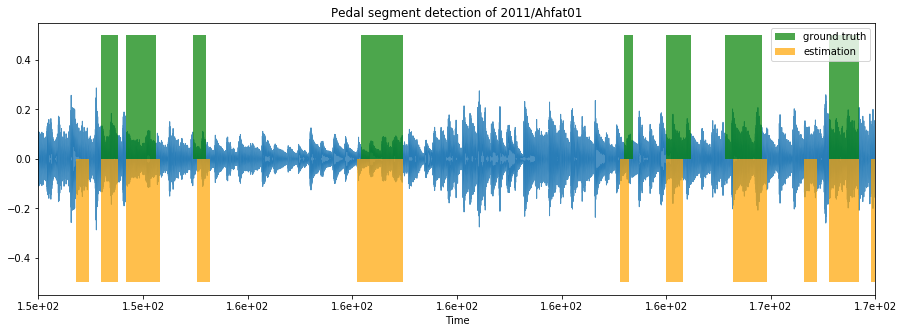

In [9]:
# plot result
frmtimes = np.arange(n_frames)*seghop_duration
left,right = [150,170]
plt.figure(figsize=(15,5))
librosa.display.waveplot(paudio, SR, alpha=0.8)
plt.fill_between(frmtimes, 0, 0.5, where=segframes_gt>0, facecolor='green', alpha=0.7, label='ground truth')
plt.fill_between(frmtimes, -0.5, 0, where=segframes_est>0, facecolor='orange', alpha=0.7, label='estimation')
plt.title("Pedal segment detection of {}".format(filename))
plt.legend()
plt.xlim([left,right])

In [ ]:
# paudio_rmse = librosa.feature.rmse(y=paudio, hop_length=HOP_LENGTH)
# paudio_rmse_norm = (paudio_rmse[0]-min(paudio_rmse[0]))/(max(paudio_rmse[0])-min(paudio_rmse[0]))
# paudio_rmse_norm_filter = medfilt(paudio_rmse_norm,11)
# frmtime_rmse = np.arange(len(paudio_rmse_norm))*0.01

# plt.figure(figsize=(20,8))
# axes = plt.gca()
# ymin, ymax = axes.get_ylim()
# # plt.axhline(0.98, label='seg threshold', color='gray')
# plt.vlines(pedal_onset_gt,ymin, ymax, label='gt onset', color='yellow', lw=2)
# plt.vlines(longseg_onset_gt, ymin, ymax, label='gt long onset', color='red', lw=2)
# plt.vlines(longseg_onset_gt+0.3, ymin, ymax, linestyles='dashed', color='black', lw=1)
# plt.vlines(pedal_offset_gt, ymin, ymax, label='gt offset', color='black', lw=2)
# plt.plot(frmtime_ponset, pred_ponset_todetect, '-', label='predicted pedal onset', alpha=0.7)
# plt.plot(frmtime_psegment, pred_psegment_todetect, '-', label='predicted pedal segment', alpha=0.5)
# for idx in range(len(onseg_times)):S
#     plt.axvspan(onseg_times[idx],offseg_times[idx], ymin, ymax, color='green', alpha=0.3)
# # plt.grid(True)
# # axes.minorticks_on()
# # axes.grid(which='minor')
# # plt.ylim([0.5,1])
# plt.xlim([150,170])
# plt.legend()

### Do the detection on all the pieces in the testing dataset:
```
python psegment-test_onset98_seg98.py
```

results are saved in `psegment-testresult_onset98_seg98.csv` where variables
```
[filename_records, support0s, support1s, acc01_frms, p1_frms, r1_frms, f1_frms, fp_rates, fn_rates, 
 boundary_wins, p1_sbrs, r1_sbrs, f1_sbrs, r2e_deviation1s, e2r_deviation1s,
 p01_sbrs, r01_sbrs, f01_sbrs, r2e_deviation01s, e2r_deviation01s,
 p_pairwises, r_pairwises, f_pairwises, nce_overs, nce_unders, nce_fs, rand_indexs, 
 adjrand_indexs, mutual_infos, adjmutual_infos, normmutual_infos]
```
are associated to column names
```
['filename_record', 'support0', 'support1', 'acc01_frm', 'p1_frm', 'r1_frm', 'f1_frm', 'fp_rate', 'fn_rate', 
 'boundary_win', 'p1_sbr', 'r1_sbr', 'f1_sbr', 'r2e_deviation1', 'e2r_deviation1',
 'p01_sbr', 'r01_sbr', 'f01_sbr', 'r2e_deviation01', 'e2r_deviation01',
 'p_pairwise', 'r_pairwise', 'f_pairwise', 'nce_over', 'nce_under', 'nce_f', 'rand_index', 
 'adjrand_index', 'mutual_info', 'adjmutual_info', 'normmutual_info']
```

### Load results:

In [2]:
# add the author associated to the piece as another column of the dataframe
author = ['Bach', 'Liszt', 'Prokofiev', 'Chopin', 'Bach', 'Beethoven', 'Prokofiev', 'Schubert', 'Dutilleux', 'Chopin', 'Chopin', 'Beethoven', 'Schedrin', 'Liszt', 'Bach', 'Beethoven', 'Chopin', 'Rachmaninov', 'Ravel', 'Prokofiev', 'Schubert', 'Liszt', 'Schumann', 'Mendelssohn', 'Prokofiev', 'Stravinsky', 'Bach', 'Beethoven', 'Scriabin', 'Debussy', 'Chopin', 'Beethoven', 'Prokofiev', 'Bach', 'Beethoven', 'Chopin', 'Scriabin', 'Liszt', 'Schubert', 'Barber', 'Bach', 'Beethoven', 'Chopin', 'Chopin', 'Liszt', 'Schubert', 'Prokofiev', 'Kreisler', 'Beethoven', 'Rachmaninov', 'Bach', 'Haydn', 'Chopin', 'Chopin', 'Liszt', 'Haydn', 'Mozart', 'Bach', 'Beethoven', 'Schumann', 'Liszt', 'Bach', 'Clementi', 'Stravinsky', 'Liszt', 'Schubert', 'Chopin', 'Dutilleux', 'Bach', 'Beethoven', 'Chopin', 'Kuzmenko', 'Bach', 'Mozart', 'Liszt', 'Barber', 'Schubert', 'Chopin', 'Prokofiev', 'Haydn', 'Chopin', 'Bach', 'Ligeti', 'Rachmaninov', 'Beethoven', 'Schubert', 'Schubert', 'Barber', 'Chopin', 'Beethoven', 'Rachmaninov', 'Bach', 'Mozart', 'Chopin', 'Liszt', 'Liszt', 'Rachmaninov', 'Schubert', 'Schubert', 'Szymanowski', 'Haydn', 'Mendelssohn', 'Mendelssohn', 'Balakirev', 'Liszt', 'Bach', 'Beethoven', 'Chopin', 'Chopin', 'Bach', 'Chopin', 'Beethoven', 'Mendelssohn', 'Liszt', 'Schubert', 'Poulenc', 'Mendelssohn', 'Prokofiev', 'Bach', 'Beethoven', 'Chopin', 'Chopin', 'Bach', 'Beethoven', 'Chopin', 'Chopin', 'Bach', 'Chopin', 'Beethoven', 'Prokofiev', 'Bach', 'Beethoven', 'Ravel', 'Kapustin', 'Schubert', 'Prokofiev', 'Schubert', 'Gershwin', 'Liszt', 'Beethoven', 'Chopin', 'Liszt', 'Bach', 'Beethoven', 'Chopin', 'Chopin', 'Schubert', 'Liszt', 'Prokofiev', 'Mendelssohn', 'Ravel', 'Gao', 'Chopin', 'Liszt', 'Bach', 'Beethoven', 'Chopin', 'Balakirev', 'Bach', 'Chopin', 'Mozart', 'Chopin', 'Bach', 'Haydn', 'Chopin', 'Schumann', 'Schubert', 'Chopin', 'Prokofiev', 'Liszt', 'Mendelssohn', 'Debussy', 'Chopin']

testresult_path = 'psegment-testresult_onset98_seg98.csv'
testresult_tracks = pd.read_csv(testresult_path)
testresult_tracks['author'] = author
num_testresult_tracks = len(testresult_tracks)

print("Related statistics of testing dataset")
print("Sum of # frame label 'np': {}".format(sum(testresult_tracks.support0.values)))
print("Sum of # frame label  'p': {}".format(sum(testresult_tracks.support1.values)))
print("  Average boundary window: {0:.4f}s".format(sum(testresult_tracks.boundary_win.values)/num_testresult_tracks))
print("         Number of pieces: {}".format(num_testresult_tracks))

print("=" * 60)
print("Average metrics for frame-wise label 'p'")
print("-" * 50)
print("            Accuracy: {0:.4f}".format(sum(testresult_tracks.acc01_frm.values)/num_testresult_tracks))
print("           Precision: {0:.4f}".format(sum(testresult_tracks.p1_frm.values)/num_testresult_tracks))
print("              Recall: {0:.4f}".format(sum(testresult_tracks.r1_frm.values)/num_testresult_tracks))
print("                  F1: {0:.4f}".format(sum(testresult_tracks.f1_frm.values)/num_testresult_tracks))
print("             FP rate: {0:.4f}".format(sum(testresult_tracks.fp_rate.values)/num_testresult_tracks))
print("             FN rate: {0:.4f}".format(sum(testresult_tracks.fn_rate.values)/num_testresult_tracks))

print("=" * 60)
print("Average metrics for boundary annotation 'p'")
print("-" * 50)
print("           Precision: {0:.4f}".format(sum(testresult_tracks.p1_sbr.values)/num_testresult_tracks))
print("              Recall: {0:.4f}".format(sum(testresult_tracks.r1_sbr.values)/num_testresult_tracks))
print("           F-measure: {0:.4f}".format(sum(testresult_tracks.f1_sbr.values)/num_testresult_tracks))
print("Ref-to-est deviation: {0:.4f}".format(sum(testresult_tracks.r2e_deviation1.values)/num_testresult_tracks))
print("Est-to-ref deviation: {0:.4f}".format(sum(testresult_tracks.e2r_deviation1.values)/num_testresult_tracks))

print("=" * 60)
print("Average metrics for structural annotation (p+np)")
print("-" * 50)
print("  Pairwise Precision: {0:.4f}".format(sum(testresult_tracks.p_pairwise.values)/num_testresult_tracks))
print("     Pairwise Recall: {0:.4f}".format(sum(testresult_tracks.r_pairwise.values)/num_testresult_tracks))
print("  Pairwise F-measure: {0:.4f}".format(sum(testresult_tracks.f_pairwise.values)/num_testresult_tracks))
print("          Rand Index: {0:.4f}".format(sum(testresult_tracks.rand_index.values)/num_testresult_tracks))
print("            NCE Over: {0:.4f}".format(sum(testresult_tracks.nce_over.values)/num_testresult_tracks))
print("           NCE Under: {0:.4f}".format(sum(testresult_tracks.nce_under.values)/num_testresult_tracks))

print("=" * 60)
print("Average metrics for boundary annotation (p+np)")
print("-" * 50)
print("           Precision: {0:.4f}".format(sum(testresult_tracks.p01_sbr.values)/num_testresult_tracks))
print("              Recall: {0:.4f}".format(sum(testresult_tracks.r01_sbr.values)/num_testresult_tracks))
print("           F-measure: {0:.4f}".format(sum(testresult_tracks.f01_sbr.values)/num_testresult_tracks))
print("Ref-to-est deviation: {0:.4f}".format(sum(testresult_tracks.r2e_deviation01.values)/num_testresult_tracks))
print("Est-to-ref deviation: {0:.4f}".format(sum(testresult_tracks.e2r_deviation01.values)/num_testresult_tracks))

Related statistics of testing dataset
Sum of # frame label 'np': 282795
Sum of # frame label  'p': 435999
  Average boundary window: 0.4757s
         Number of pieces: 173
Average metrics for frame-wise label 'p'
--------------------------------------------------
            Accuracy: 0.7964
           Precision: 0.8572
              Recall: 0.6655
                  F1: 0.7422
             FP rate: 0.1468
             FN rate: 0.3345
Average metrics for boundary annotation 'p'
--------------------------------------------------
           Precision: 0.7988
              Recall: 0.5237
           F-measure: 0.6164
Ref-to-est deviation: 0.3135
Est-to-ref deviation: 1.0164
Average metrics for structural annotation (p+np)
--------------------------------------------------
  Pairwise Precision: 0.7660
     Pairwise Recall: 0.7171
  Pairwise F-measure: 0.7361
          Rand Index: 0.6885
            NCE Over: 0.3569
           NCE Under: 0.4316
Average metrics for boundary annotation (p+np)
-

(0, 0.5)

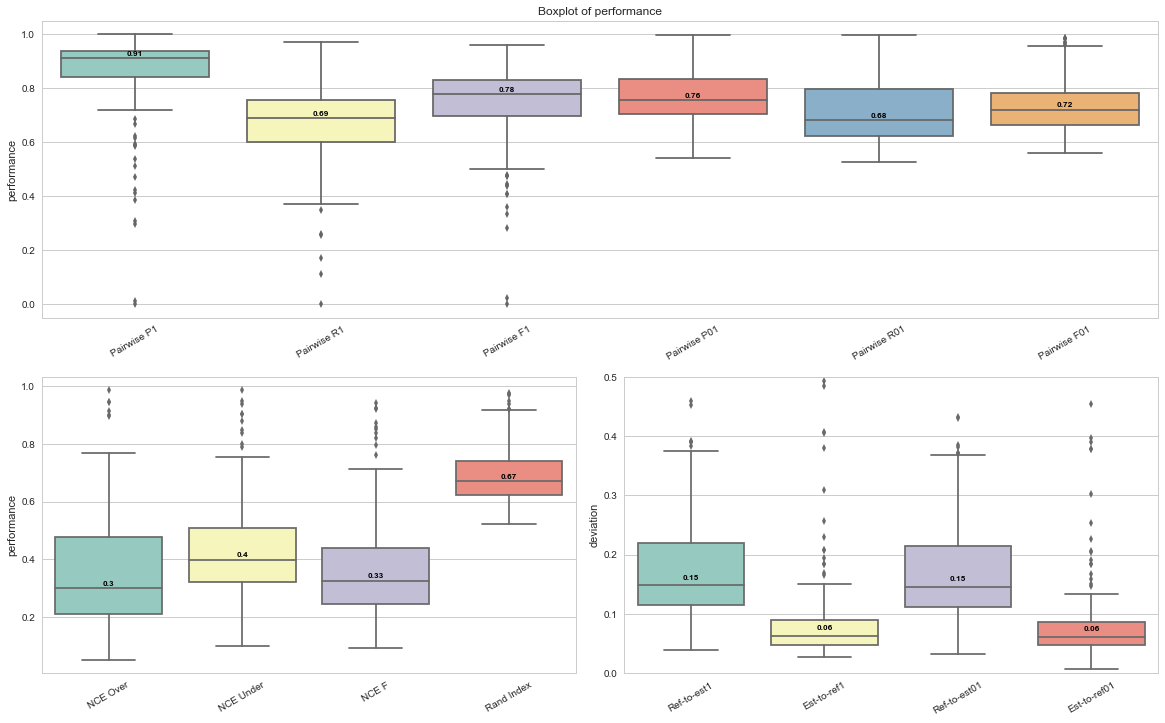

In [4]:
import seaborn as sns
plt.figure(figsize=(20,12))
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
sns.set(style="whitegrid", palette='Set3')
column_names_toplot = ['p1_frm', 'r1_frm', 'f1_frm',
                       'p1_sbr', 'r1_sbr', 'f1_sbr',  
                       'p_pairwise', 'r_pairwise', 'f_pairwise',
                       'p01_sbr', 'r01_sbr', 'f01_sbr']
column_names_toplot = ['p1_frm', 'r1_frm', 'f1_frm', 
                       'p_pairwise', 'r_pairwise', 'f_pairwise']
ax_sns = sns.boxplot(data=testresult_tracks, order=column_names_toplot)
ax1.set_xticklabels(['Pairwise P1', 'Pairwise R1', 'Pairwise F1',
                     'Boundary P1', 'Boundary R1', 'Boundary F1',  
                     'Pairwise P01', 'Pairwise R01', 'Pairwise F01',
                     'Boundary P01', 'Boundary R01', 'Boundary F01'])
ax1.set_xticklabels(['Pairwise P1', 'Pairwise R1', 'Pairwise F1',  
                     'Pairwise P01', 'Pairwise R01', 'Pairwise F01'])
plt.xticks(rotation=30)
medians = testresult_tracks[column_names_toplot].median().values
median_labels = [str(np.round(s,2)) for s in medians]
pos = range(len(median_labels))
for tick in pos:
    ax_sns.text(pos[tick], medians[tick]+0.01, median_labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
# plt.xlabel("type")
plt.ylabel("performance")
plt.title("Boxplot of performance") 

ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=2)
sns.set(style="whitegrid", palette='Set3')
column_names_toplot = ['nce_over', 'nce_under', 'nce_f', 'rand_index']
ax_sns = sns.boxplot(data=testresult_tracks, order=column_names_toplot)

medians = testresult_tracks[column_names_toplot].median().values
median_labels = [str(np.round(s,2)) for s in medians]
pos = range(len(median_labels))
for tick in pos:
    ax_sns.text(pos[tick], medians[tick]+0.01, median_labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
ax2.set_xticklabels(['NCE Over', 'NCE Under', 'NCE F', 'Rand Index'])
plt.xticks(rotation=30)
plt.ylabel("performance")

ax3 = plt.subplot2grid((2, 4), (1, 2), colspan=2)
sns.set(style="whitegrid", palette='Set3')
column_names_toplot = ['r2e_deviation1', 'e2r_deviation1', 
                       'r2e_deviation01', 'e2r_deviation01']
ax_sns = sns.boxplot(data=testresult_tracks, order=column_names_toplot)

medians = testresult_tracks[column_names_toplot].median().values
median_labels = [str(np.round(s,2)) for s in medians]
pos = range(len(median_labels))
for tick in pos:
    ax_sns.text(pos[tick], medians[tick]+0.01, median_labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
ax3.set_xticklabels(['Ref-to-est1', 'Est-to-ref1', 'Ref-to-est01', 'Est-to-ref01'])
plt.xticks(rotation=30)
plt.ylabel("deviation")
plt.ylim([0,0.5])

In [8]:
author_born = [1685, 1837, 1910, 1770, 1810, 1752, 
               1862, 1916, 1970, 1898, 1732, 1937, 
               1875, 1956, 1923, 1811, 1809, 1756,
               1899, 1891, 1873, 1875, 1932, 
               1797, 1810, 1871, 1882, 1882]

author_bornsort = np.unique(author)[np.argsort(author_born)]

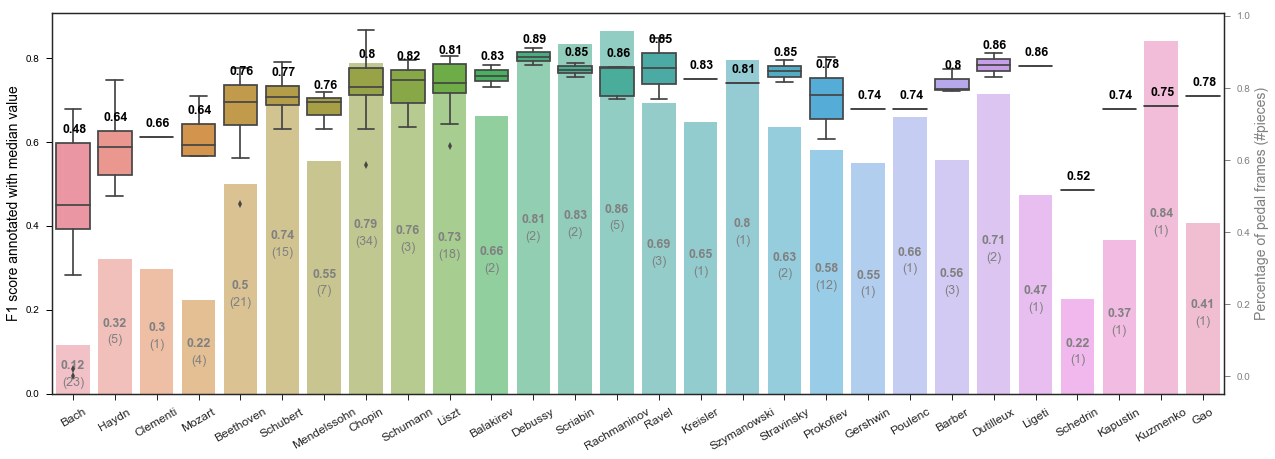

In [100]:
# plt.figure(figsize=(20,12))
# ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
# sns.set(style="whitegrid", palette='Set3')
# ax1_sns = sns.boxplot(x="author", y="f1_frm", data=testresult_tracks, order=author_bornsort)
# num_authorpiece = [len(testresult_tracks.loc[testresult_tracks['author'] == name]) for name in author_bornsort]
# medians = [np.median(testresult_tracks.loc[testresult_tracks['author'] == name].f1_frm.values) for name in author_bornsort]
# median_labels = [str(np.round(s,2)) for s in medians]
# maxvalues = [max(testresult_tracks.loc[testresult_tracks['author'] == name].f1_frm.values) for name in author_bornsort]
# xticks_loc, _ = plt.xticks(rotation=30)
# pos = range(len(num_authorpiece))
# for tick in pos:
#     ax1_sns.text(xticks_loc[tick], 0.2, num_authorpiece[tick], 
#                 horizontalalignment='center', size='x-small', color='gray')
#     ax1_sns.text(xticks_loc[tick], medians[tick]+0.01, median_labels[tick], 
#                 horizontalalignment='center', size='x-small', color='black', weight='semibold')
# plt.axhline(sum(testresult_tracks.f1_frm.values)/num_testresult_tracks, linestyle='--')
# plt.ylabel("Pairwise F1")
# plt.title("Boxplot of F1 ordered by author") 

# ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=4)
# sns.set(style="whitegrid", palette='Set3')
# num_authorsupport0 = [sum(testresult_tracks.loc[testresult_tracks['author'] == name].support0.values) for name in author_bornsort]
# num_authorsupport1 = [sum(testresult_tracks.loc[testresult_tracks['author'] == name].support1.values) for name in author_bornsort]
# percentage_authorsupport1 = [num_authorsupport1[idx]/(num_authorsupport0[idx]+num_authorsupport1[idx]) for idx in range(len(np.unique(author)))]
# ax2_sns = sns.barplot(x=author_bornsort, y=percentage_authorsupport1)
# xticks_loc, _ = plt.xticks(rotation=30)
# pos = range(len(num_authorpiece))
# percentage_label = [str(np.round(s,2)) for s in percentage_authorsupport1]
# for tick in pos:
#     ax2_sns.text(xticks_loc[tick], percentage_authorsupport1[tick]+0.01, percentage_label[tick], 
#                 horizontalalignment='center', size='x-small', color='black', weight='semibold')
# plt.ylabel("Percentage of label 1")

num_authorpiece = [len(testresult_tracks.loc[testresult_tracks['author'] == name]) for name in author_bornsort]
pos = range(len(num_authorpiece))
quartile3rd = [np.percentile(testresult_tracks.loc[testresult_tracks['author'] == name].f1_frm.values, 75) for name in author_bornsort]
medians = [np.median(testresult_tracks.loc[testresult_tracks['author'] == name].f1_frm.values) for name in author_bornsort]
median_labels = [str(np.round(s,2)) for s in medians]
maxvalues = [max(testresult_tracks.loc[testresult_tracks['author'] == name].f1_frm.values) for name in author_bornsort]
num_authorsupport0 = [sum(testresult_tracks.loc[testresult_tracks['author'] == name].support0.values) for name in author_bornsort]
num_authorsupport1 = [sum(testresult_tracks.loc[testresult_tracks['author'] == name].support1.values) for name in author_bornsort]
percentage_authorsupport1 = [num_authorsupport1[idx]/(num_authorsupport0[idx]+num_authorsupport1[idx]) for idx in range(len(np.unique(author)))]
percentage_label = [str(np.round(s,2)) for s in percentage_authorsupport1]

plt.figure(figsize=(21,7))
fig, ax1 = plt.subplots(figsize=(21,7))
sns.set(style="ticks", palette='Set3')
ax1_sns = sns.barplot(x=author_bornsort, y=percentage_authorsupport1, alpha=0.6)
xticks_loc, _ = plt.xticks(rotation=30, fontsize=12)
# plt.xlabel('Composer ordered by lifetime', color='black', fontsize=14)
for tick in pos:
    ax1_sns.text(xticks_loc[tick], percentage_authorsupport1[tick]/2, percentage_label[tick], 
                horizontalalignment='center', fontsize=12.5, color='gray', weight='bold')
    ax1_sns.text(xticks_loc[tick], percentage_authorsupport1[tick]/2-0.04, '({})'.format(num_authorpiece[tick]), 
                horizontalalignment='center', fontsize=12.5, color='gray')
ax1.set_ylabel('F1 score annotated with median value', color='black', fontsize=14)
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
ax2_sns = sns.boxplot(x="author", y="f1_frm", data=testresult_tracks, order=author_bornsort)
for tick in pos:    
    ax2_sns.text(xticks_loc[tick]+0.028, quartile3rd[tick]+0.028, median_labels[tick], rotation=0,
                horizontalalignment='center', fontsize=12.5, color='black', weight='bold')
# plt.axhline(sum(testresult_tracks.f1_frm.values)/num_testresult_tracks, linestyle='--')
ax2.set_ylabel('Percentage of pedal frames (#pieces)', color='gray', fontsize=14)
ax2.tick_params('y', colors='gray')

plt.savefig("testfig.png", bbox_inches="tight", dpi=300)